<a href="https://colab.research.google.com/github/omerhac/flower_calssification/blob/master/flower_classificaiton_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt
import math, os, sys, re
import numpy as np
import tensorflow as tf
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
print("tf version: " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

tf version: 2.2.0-rc3


# Hardware detection


In [2]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)


INFO:tensorflow:Initializing the TPU system: grpc://10.22.64.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.64.162:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU  grpc://10.22.64.162:8470
Number of accelerators:  8


## Utilities

In [0]:
def get_numpy_batch(dataset, n_samples):
  """get numpy array of n samples"""
  dataset = dataset.shuffle(buffer_size=10)
  batched = dataset.batch(n_samples)
  for images, labels in batched:
    return images.numpy(), labels.numpy()

def show_n_samples(dataset, n):
  """prints n images and labels"""
  plt.figure(figsize = (2 * n, 2 *n))

  rows = math.ceil(n / 3)

  batch_images, batch_labels = get_numpy_batch(dataset, n)

  for i, image in enumerate(batch_images):
    plt.subplot(rows, 3, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[batch_labels[i]])
  
  plt.show()

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def count_dataset_items(dataset):
  # counts items iterativly in the data set. requaiers some time...
  count = 0
  for obj in dataset:
    count += 1
  
  return count

def display_training_curves(hist, metric='accuracy', with_val=False):
  """display learning curves for keras history dict, args: history dict, with val --> boolean with/without val"""
  plt.figure(figsize=(18,6))

  # accuracy plots
  plt.subplot(1,2,1)
  plt.plot(hist[metric])
  
  if with_val:
    plt.plot(hist['val_' + metric])
    plt.legend(['Train', 'Validation'])
  
  else:
    plt.legend(['Train'])
  
  plt.title('Model accuracy')
  plt.xlabel('EPOCH')
  plt.ylabel('Accuracy')

  # loss plots
  plt.subplot(1,2,2)
  plt.plot(hist['loss'])

  if with_val:
    plt.plot(hist['val_loss'])
    plt.legend(['Train loss', 'Val loss'])
  
  else:
    plt.legend(['Train loss'])
  
  plt.title('Model loss')
  plt.xlabel('EPOCH')
  plt.ylabel('Loss')
  plt.show()

def display_training_curves_without_dict(accuracy, val_accuracy, loss, val_loss):
  """display learning curves. args: accuracy iterable, val iterable , loss iterable, val_los iterable"""
  keras_dict = {'accuracy': accuracy, 'val_accuracy': val_accuracy, 'loss': loss, 'val_loss': val_loss}
  return display_training_curves(keras_dict)

  
def display_model_predictions(model, dataset):
  """Displays 9 images and their predictions"""

  batch_images, batch_labels = get_numpy_batch(dataset, 9)
  predictions = model.predict(batch_images) # predict images labels
  
  plt.figure(figsize=(18,18))

  for i, image in enumerate(batch_images):
    # def plot
    plt.subplot(3,3,i + 1)
    plt.imshow(image)

    # write prediction as titles
    pred =np.argmax(predictions[i])
    if pred == batch_labels[i]:
      plt.title(CLASSES[pred], fontdict={'color':'g'})

    else:
      plt.title(CLASSES[pred] + " WRONG --> " + CLASSES[batch_labels[i]], fontdict={'color': 'r'})
    
  plt.show()



# Loading images

In [0]:
# read tfrecords from gcs
def read_tfrecord(example):
  """Parses one tf record to image, class, one_hot_class"""
  features = {
      "image": tf.io.FixedLenFeature([], tf.string),
      "class": tf.io.FixedLenFeature([], tf.int64),
  }

  example = tf.io.parse_example(example, features)
  image = tf.image.decode_jpeg(example['image'], channels=3)
  image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
  image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size will be needed for TPU
  label = tf.cast(example['class'], tf.int32)
  return image, label

def load_tfrecord_dataset(dataset_filenames):
  """Loads a TFRecord dataset. args: dataset_filnames --> list of strings of files paths"""

  # allows for no order parallel reading
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(dataset_filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_dataset(training_filenames, train=True, augment_func=None):
  """ Read dataset from tfrecords, shuffle and prefetch it"""

  dataset = load_tfrecord_dataset(training_filenames)
  dataset = dataset.shuffle(2048)

  # augment data if function is available
  if augment_func:
    dataset = dataset.map(augment_func, num_parallel_calls=AUTO)

  dataset = dataset.batch(BATCH_SIZE)
  
  # repeat dataset for training data
  if train:
    dataset = dataset.repeat()

  dataset = dataset.prefetch(AUTO)

  return dataset


In [9]:
# getting image paths
IMAGE_SIZE = [192, 192]

GCS_PATH = "gs://kds-b2e6cdbc4af76dcf0363776c09c12fe46872cab211d1de9f60ec7aec" # GCS path for competition data

# dict for paths to different image sizes
GCS_PATH_SELECT = { # available image sizes
    192: GCS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_PATH + '/tfrecords-jpeg-512x512'
}

# get full path with image size and split to train / val / test
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# get length of datasets
TRAINING_LENGTH = count_data_items(TRAINING_FILENAMES)
VALIDATION_LENGTH = count_data_items(VALIDATION_FILENAMES)
TEST_LENGTH = count_data_items(TEST_FILENAMES)

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
STEPS_PER_EPOCH = TRAINING_LENGTH // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(TRAINING_LENGTH,VALIDATION_LENGTH, TEST_LENGTH))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


In [15]:
whole_dataset = get_dataset(TRAINING_FILENAMES + VALIDATION_FILENAMES)
training_dataset = get_dataset(TRAINING_FILENAMES, augment_func=augment_image)
validation_dataset = get_dataset(VALIDATION_FILENAMES, train=False)
test_dataset = load_tfrecord_dataset(TEST_FILENAMES) # have to create a function to load test items from tfrecord

print("Steps per epoch: {}".format(STEPS_PER_EPOCH))

Steps per epoch: 99


## Flower classes


In [0]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Data augmentation

In [0]:
def random_scale_and_shift(image, resize_lower_threshold=0.5):
  """ A function that with probability 0.5 takes an image, resize (randomly between resize_lower_threshold and 1) and shifts it by random values."""

  if np.random.rand() > 0.5:
    return image

  height, width, _ = image.shape
  resize_ratio = np.random.uniform(low=resize_lower_threshold, high=1) # set resize ratio

  # get new dimensions
  new_height = int(resize_ratio * height)
  new_width = int(resize_ratio * width)  

  # resize image
  resized_image = tf.image.resize(image, size=tf.constant([new_height, new_width], dtype='int32'))

  # shit image
  new_image = np.random.uniform(size=image.shape) # create ranodm noise image
  row_start = np.random.randint(0, high=height-new_height)
  column_start = np.random.randint(0, high=width-new_width)
  new_image[row_start:row_start+new_height, column_start:column_start+new_width,:] = resized_image

  return new_image

def augment_image(image, label):
  
  """Randomly flip and saturate an image. args: image, label"""
  aug_image = tf.image.random_flip_left_right(image)
  aug_image = random_scale_and_shift(image)

  return aug_image, label


def augment_tf_dataset(dataset):
  double_data = dataset
  
  return double_data.map(augment_image, num_parallel_calls=AUTO)
  

# Simple transfer learning model

*   untrainable weights



In [0]:
def get_pretrained_model(trainable=False):
  # get xception / densenet / inception pretrained model
  pretrained = keras.applications.InceptionResNetV2(include_top=False, input_shape=[*IMAGE_SIZE,3])
  #pretrained = keras.applications.Xception(include_top=False, input_shape=[*IMAGE_SIZE,3])
  #pretrained = tf.keras.applications.DenseNet201(include_top=False, input_shape=[*IMAGE_SIZE,3], weights='imagenet')
  pretrained.trainable = trainable

  # define model
  model = tf.keras.models.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
  return model

In [0]:
#with strategy.scope():
  #model = get_pretrained_model()
  #model.summary()

In [0]:
#hist = model.fit(batched_training_dataset, epochs=3, validation_data=batched_validation_dataset)

In [0]:
#display_training_curves(hist.history, metric='sparse_categorical_accuracy', with_val=True)

# Compute unbalanced class weights

In [0]:
from sklearn.utils import class_weight
y_train = training_dataset.map(lambda image, label: label).as_numpy_iterator()
y_train = [x for x in y_train]
class_weights = class_weight.compute_class_weight('balanced', [x for x in range(len(CLASSES))], y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))} # converting to dict

# Transfer learning with trainable weights

In [0]:
with strategy.scope():
  model = get_pretrained_model(trainable=True)
  model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_9 ( (None, 1536)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 104)               159848    
Total params: 54,496,584
Trainable params: 54,436,040
Non-trainable params: 60,544
_________________________________________________________________


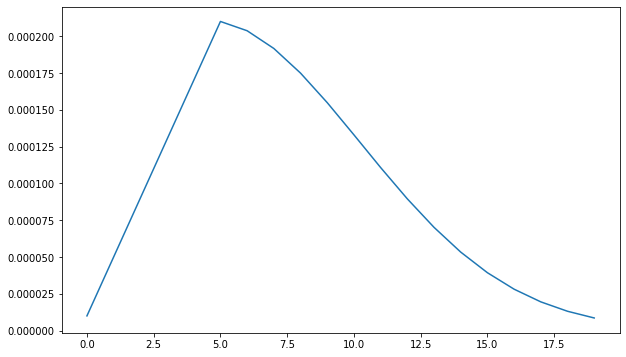

In [0]:
def step_lr_schedule(epoch, current, decay_rate=0.8, initial_lr=1e-5, linear_slope= 1e-5, peak_slope=5):
  """transfer learning step scheduler. args: epoch number, curren learning rate"""

  if epoch <= peak_slope:
    return initial_lr + linear_slope * epoch
  else:
    return current * decay_rate**(epoch-peak_slope)

def get_transfer_learning_schedule(decay_rate=0.8, initial_lr=1e-5, linear_slope=1e-5, peak_slope=5):
  """Get a learning rate step scheduler. args: parameters for the step curve"""

  return lambda epoch, current: step_lr_schedule(epoch, current, decay_rate, initial_lr, linear_slope, peak_slope)

def plot_lr_schedule(lr_schedule, num_epochs):
  """ given a learning schedule function, prints its graph"""

  current = 0 # initial learning rate
  lrs = []
  epochs = range(num_epochs)
  for epoch in epochs:
    lr = lr_schedule(epoch, current)
    current = lr # change current learning rate to function outcome
    lrs.append(lr)

  plt.figure(figsize=(10,6))
  plt.plot(epochs, lrs)

transfer_lr_schedule = get_transfer_learning_schedule(decay_rate=0.97, initial_lr=1e-5, linear_slope=4e-5, peak_slope=5)

# visualize lr
plot_lr_schedule(transfer_lr_schedule, 20)

In [0]:
## creating callbacks
schedule = tf.keras.callbacks.LearningRateScheduler(transfer_lr_schedule, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='auto', restore_best_weights=True, patience=3, verbose=1)
model_chkpt = tf.keras.callbacks.ModelCheckpoint(filepath='chkpt', monitor='sparse_categorical_crossentropy', verbose=1, period=5)

In [0]:
# train_model
hist = model.fit(training_dataset, epochs = 25,
                 callbacks=[schedule, early_stopping], validation_data=batched_validation_dataset, steps_per_epoch=STEPS_PER_EPOCH)#, class_weight=class_weights)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
99/99 [==============================] - ETA: 0s - loss: 4.4164 - sparse_categorical_accuracy: 0.0971WARNING:tensorflow:Model was constructed with shape (None, 192, 192, 3) for input Tensor("inception_resnet_v2_input_1:0", shape=(None, 192, 192, 3), dtype=float32), but it was called on an input with incompatible shape (None, 331, 331, 3).


99/99 [==============================] - 55s 558ms/step - loss: 4.4164 - sparse_categorical_accuracy: 0.0971 - val_loss: 4.4569 - val_sparse_categorical_accuracy: 0.1851 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 5e-05.
Epoch 2/25
99/99 [==============================] - ETA: 0s - loss: 2.5468 - sparse_categorical_accuracy: 0.4590WARNING:tensorflow:Model was constructed with shape (None, 192, 192, 3) for input Tensor("inception_resnet_v2_input_1:0", shape=(None, 192, 192, 3), dtype=float32), but it was called on an input with incompatible shape (None, 331, 331, 3).


KeyboardInterrupt: ignored

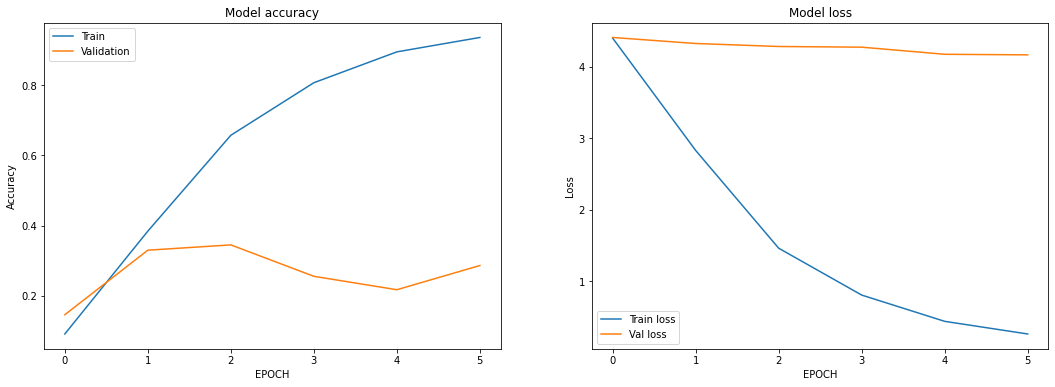

In [0]:
display_training_curves(hist.history, metric='sparse_categorical_accuracy', with_val=True)

In [0]:
display_model_predictions(model, validation_dataset)

# Custom cnns

## Inception

In [21]:
from tensorflow.keras.layers import SeparableConv2D, Conv2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D, concatenate, Input
from tensorflow.keras import  Model

def inception_block(x, num_3_filters, num_1_filters, batch_norm_moment = 0.9):
  """ Get InceptionV2 style block"""
  side_pool = MaxPooling2D(pool_size=(2,2))(x)
  # middle branch
  middle_branch_1 = SeparableConv2D(num_1_filters, kernel_size=(1,1), strides=(1,1), activation = 'relu', padding='same')(x)
  middle_branch_1 = BatchNormalization(momentum=batch_norm_moment)(middle_branch_1)
  middle_branch_3 = SeparableConv2D(num_3_filters, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(middle_branch_1)
  middle_branch_3 = BatchNormalization(momentum=batch_norm_moment)(middle_branch_3)

  # big branch
  big_branch_1 = SeparableConv2D(num_1_filters, kernel_size=(1,1), strides=(1,1), activation = 'relu', padding='same')(x)
  big_branch_1 = BatchNormalization(momentum=batch_norm_moment)(big_branch_1)
  big_branch_3_1 = SeparableConv2D(num_3_filters, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(big_branch_1)
  big_branch_3_1 = BatchNormalization(momentum=batch_norm_moment)(big_branch_3_1)
  big_branch_3_2 = SeparableConv2D(num_3_filters, kernel_size=(3,3), strides=(2,2), activation='relu', padding='same')(big_branch_3_1)
  big_branch_3_2 = BatchNormalization(momentum=batch_norm_moment)(big_branch_3_2)

  depth_concat = concatenate([side_pool, middle_branch_3, big_branch_3_2])
  
  return depth_concat

def inception(num_3_filters, num_1_filters, batch_norm_moment = 0.9):
  """ Creates an Inception v2 style layer."""
  
  return lambda x: inception_block(x, num_3_filters, num_1_filters, batch_norm_moment = 0.9)

# stem
x = Input(shape=[*IMAGE_SIZE, 3])
#mp = MaxPooling2D(pool_size=(2,2))(x)
c1 = SeparableConv2D(6, kernel_size=(3,3), padding='valid', activation='relu')(x)
c1 = BatchNormalization(momentum=0.9)(c1)
c2 = SeparableConv2D(12, kernel_size=(3,3), padding='valid', activation='relu')(c1)
c2 = BatchNormalization(momentum=0.9)(c2)
c3 = SeparableConv2D(24, kernel_size=(3,3), padding='valid', activation='relu')(c2)
c3 = BatchNormalization(momentum=0.9)(c3)
mp1 = MaxPooling2D(pool_size=(2,2))(c3)
c4 = SeparableConv2D(48, kernel_size=(3,3), padding='valid', activation='relu')(mp1)
c4 = BatchNormalization(momentum=0.9)(c4)
c5 = SeparableConv2D(96, kernel_size=(3,3), padding='valid', activation='relu')(c4)
c5 = BatchNormalization(momentum=0.9)(c5)
mp2 = MaxPooling2D(pool_size=(2,2))(c5)

# inception blocks
i1 = inception(192,96)(mp2)
i2 = inception(192,384)(i1)
i3 = inception(384,768)(i1)
g = GlobalAveragePooling2D()(i2)
d = Dense(len(CLASSES), activation='softmax')(g)
model = Model(inputs=x, outputs=d)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 190, 190, 6)  51          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 190, 190, 6)  24          separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 188, 188, 12) 138         batch_normalization[0][0]        
______________________________________________________________________________________________

## Squeezenet

In [23]:
def fire_module(x, num_squeeze_filters, num_expand_filters, bnmoment=0.9):
  """" Creates a squeezenet style block. Args: num_squeeze_filters should be about half of num_expand_filters"""

  squeeze = Conv2D(num_squeeze_filters, kernel_size=(1,1), activation='relu', padding='same')(x)
  squeeze = BatchNormalization(momentum=bnmoment)(squeeze)
  expand3 = Conv2D(num_expand_filters, kernel_size=(3,3), activation='relu', padding='same')(squeeze)
  expand3 = BatchNormalization(momentum=bnmoment)(expand3)
  expand1 = Conv2D(num_expand_filters, kernel_size=(1,1), activation='relu', padding='same')(squeeze)
  expand1 = BatchNormalization(momentum=bnmoment)(expand1)
  return concatenate([expand3, expand1])

def fire(num_squeeze_filters, num_expand_filters, bnmoment=0.9):
  """" Creates a squeezenet style layer (functional style). Args: num_squeeze_filters should be about half of num_expand_filters"""

  return lambda x: fire_module(x, num_squeeze_filters, num_expand_filters, bnmoment)

## define architecture ##
x = Input(shape=[*IMAGE_SIZE,3])
c1 = Conv2D(10, kernel_size=(3,3), activation='relu', padding='valid')(x)
c1 = BatchNormalization(momentum=0.9)(c1)
c2 = Conv2D(20, kernel_size=(3,3), activation='relu', padding='valid')(c1)
c2 = BatchNormalization(momentum=0.9)(c2)
mp1 = MaxPooling2D(pool_size=(2,2))(c2)

# add fire blocks
fire1 = fire(20,40)(mp1)
fire2 = fire(40,80)(fire1)
fire3 = fire(80,160)(fire2)
mp2 = MaxPooling2D(pool_size=(2,2))(fire3)
fire4 = fire(160,320)(mp2)
fire5 = fire(320,640)(fire4)

ga = GlobalAveragePooling2D()(fire5)
dense_out = Dense(len(CLASSES), activation='softmax')(ga)

model = Model(x, dense_out)
model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 190, 190, 10) 280         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 190, 190, 10) 40          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 188, 188, 20) 1820        batch_normalization_20[0][0]     
____________________________________________________________________________________________

## Simple model

In [37]:
def conv2d_module(x, num_filters, kernel_size, activation, padding='valid', bnmoment=0.9):
  """ Conv2d module paired with batch normalization"""

  conv = Conv2D(num_filters, kernel_size=kernel_size, activation=activation, padding=padding)(x)
  bn = BatchNormalization(momentum=bnmoment)(conv)
  return bn

def conv2d(num_filters, kernel_size, activation, padding='valid', bnmoment=0.9):
  """ Conv2d layer paired with batch normalization """
  return lambda x: conv2d_module(x, num_filters, kernel_size, activation, padding=padding, bnmoment=bnmoment)


## define architecture ##
x = Input(shape=[*IMAGE_SIZE, 3])
mp = MaxPooling2D(pool_size=(2,2))(x)
c1 = conv2d(16, (3,3), 'relu', bnmoment=0.9)(mp)
c2 = conv2d(32, (3,3), 'relu', bnmoment=0.9)(c1)
c3 = conv2d(64, (3,3), 'relu', bnmoment=0.9)(c2)
mp1 = MaxPooling2D(pool_size=(2,2))(c3)
c4 = conv2d(64, (3,3), 'relu', bnmoment=0.9)(mp1)
c5 = conv2d(128, (3,3), 'relu', bnmoment=0.9)(c4)
c6 = conv2d(256, (3,3), 'relu', bnmoment=0.9)(c5)
mp2 = MaxPooling2D(pool_size=(2,2))(c6)

flat = Flatten()(mp2)
d1 = Dense(512, activation='relu')(flat)
du1 = tf.keras.layers.Dropout(0.3)(d1)
d2 = Dense(256, activation='relu')(du1)
du2 = tf.keras.layers.Dropout(0.3)(d2)

out = Dense(len(CLASSES), activation='softmax')(du2)

model = Model(x, out)

model.compile(loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'], optimizer='adam')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
batch_normalization_49 (Batc (None, 94, 94, 16)        64        
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 92, 92, 32)        4640      
_________________________________________________________________
batch_normalization_50 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 90, 90, 64)        1849

In [0]:
model.fit(training_dataset, epochs=40, steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_dataset)

Epoch 1/40
99/99 [==============================] - 134s 1s/step - loss: 5.3997 - sparse_categorical_accuracy: 0.0414 - val_loss: 4.4613 - val_sparse_categorical_accuracy: 0.0663
Epoch 2/40
99/99 [==============================] - 133s 1s/step - loss: 4.4112 - sparse_categorical_accuracy: 0.0638 - val_loss: 4.1283 - val_sparse_categorical_accuracy: 0.1029
Epoch 3/40
99/99 [==============================] - 134s 1s/step - loss: 4.2266 - sparse_categorical_accuracy: 0.0829 - val_loss: 4.0850 - val_sparse_categorical_accuracy: 0.0959
Epoch 4/40
99/99 [==============================] - 132s 1s/step - loss: 4.1120 - sparse_categorical_accuracy: 0.0880 - val_loss: 3.9832 - val_sparse_categorical_accuracy: 0.1239
Epoch 5/40
99/99 [==============================] - 131s 1s/step - loss: 4.0559 - sparse_categorical_accuracy: 0.0955 - val_loss: 3.9435 - val_sparse_categorical_accuracy: 0.1121
Epoch 6/40
99/99 [==============================] - 133s 1s/step - loss: 3.9826 - sparse_categorical_accu

# Apply object detection

In [0]:
!git clone https://github.com/endernewton/tf-faster-rcnn.git

# Key takeaways:
* always use tf.keras and not keras!
* for a transfer learning model, its really importent to set whether the model is trainable by "pretrained_model.trainable = True/False" and not by "model.layer.trainable = True/False". not sure why..
* transfer learning is really sensitive to changes in anything..
* for a transfer learning model training you should do one of the two:
  - warmap top layers for some epochs
  - use a step curve learning rate
  - dont use both!
* pay attention to the metric.. sparse_caterogical_accuracy is very different from accuracy. also the loss..
* class weighting actually didn't let all-trainable model train!!
* dataset.repeat() must come after dataset.batch()
* image size between 512x512 and 331x331 didnt have any differance
* keras callbacks are good and easy to use
  - for ModelCheckpoint you should mount google drive
* there isnt much difference in accuracy on top notch transfer learning models
* custom cnn architecture
 -  complicated architecures (with filter depth concat) takes relativly long time to train. seperable convolution has a big advantage in training time
 - you should reduce the dimensionality of the input before feeding it to complicated modules
 - you should use 'same' padding on conv and maxpool layers when matching dimensions are needed (usually within a block before a depth concat)
 - complicated models require aaalot of data.... da
 - batch normalization is time consuming
 - global avarage pooling is as effective as a dense last layer for a very deep network
  - its really hard getting good accuracy with trained from scratch models on a 17000 image dataset..